# Modelovanie č. 1 - klasifikačné metódy


## Načítanie knižníc

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pickle

from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

## Načítanie dát

In [27]:
with open('data/Train_data_preprocessed.pkl', 'rb') as file:
    data = pickle.load(file)

## Rozdelenie dát na trénovacie a testovacie

In [28]:
X_train, X_test, y_train, y_test = train_test_split(data.drop(columns=['class']), data['class'], test_size=0.3, random_state=42)

## Normalizácia dát pomocou StandardScaler

In [29]:
quantitative = ['src_bytes', 'dst_bytes', 'hot', 'count', 'serror_rate', 'rerror_rate', 'diff_srv_rate', 'dst_host_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate']

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train[quantitative])
X_test = scaler.transform(X_test[quantitative])

## Modelovanie

In [30]:
rf = RandomForestClassifier()
knn = KNeighborsClassifier()

rf.fit(X_train, y_train)
knn.fit(X_train, y_train)

models = (
    ('Random Forest', rf),
    ('KNN', knn)
)

## Vyhodnotenie modelov

Random Forest Specificity: 0.9945
Random Forest Accuracy: 0.9963
{'Normal': {'precision': 0.9945429740791268, 'recall': 0.9986301369863013, 'f1-score': 0.9965823650034177, 'support': 3650.0}, 'Anomaly': {'precision': 0.9983509234828496, 'recall': 0.9934361667213653, 'f1-score': 0.9958874814936667, 'support': 3047.0}, 'accuracy': 0.9962669852172614, 'macro avg': {'precision': 0.9964469487809882, 'recall': 0.9960331518538332, 'f1-score': 0.9962349232485421, 'support': 6697.0}, 'weighted avg': {'precision': 0.9962755142961109, 'recall': 0.9962669852172614, 'f1-score': 0.9962662070141372, 'support': 6697.0}}


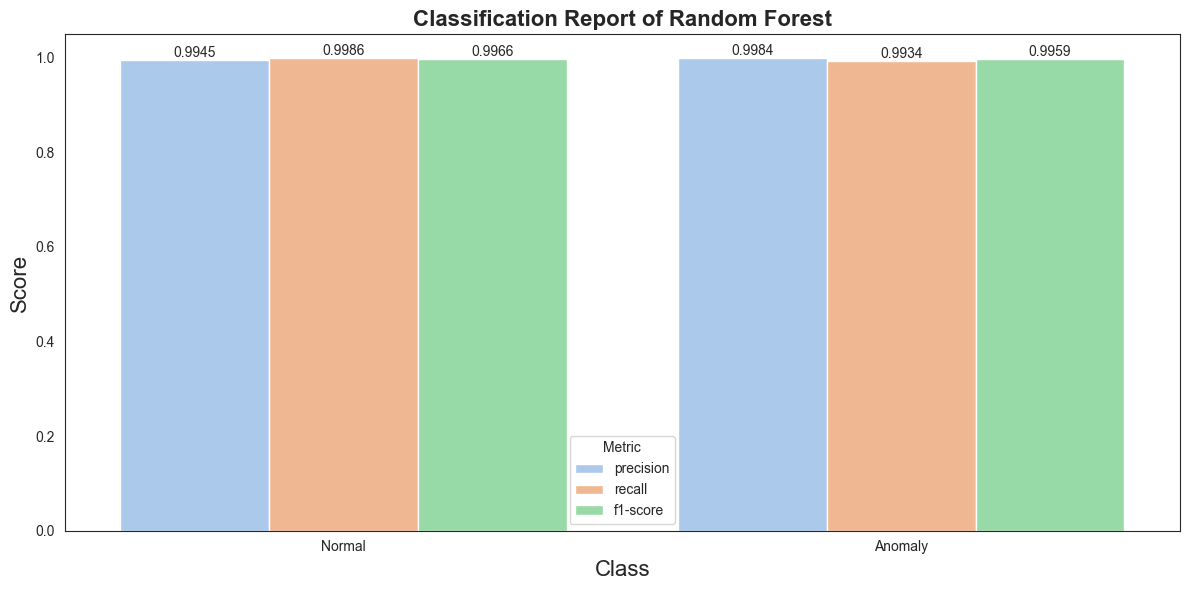

KNN Specificity: 0.9915
KNN Accuracy: 0.9928
{'Normal': {'precision': 0.9915393013100436, 'recall': 0.9953424657534247, 'f1-score': 0.9934372436423298, 'support': 3650.0}, 'Anomaly': {'precision': 0.9943949884602704, 'recall': 0.9898260584181162, 'f1-score': 0.9921052631578947, 'support': 3047.0}, 'accuracy': 0.992832611617142, 'macro avg': {'precision': 0.992967144885157, 'recall': 0.9925842620857704, 'f1-score': 0.9927712534001123, 'support': 6697.0}, 'weighted avg': {'precision': 0.9928385813976562, 'recall': 0.992832611617142, 'f1-score': 0.9928312193723472, 'support': 6697.0}}


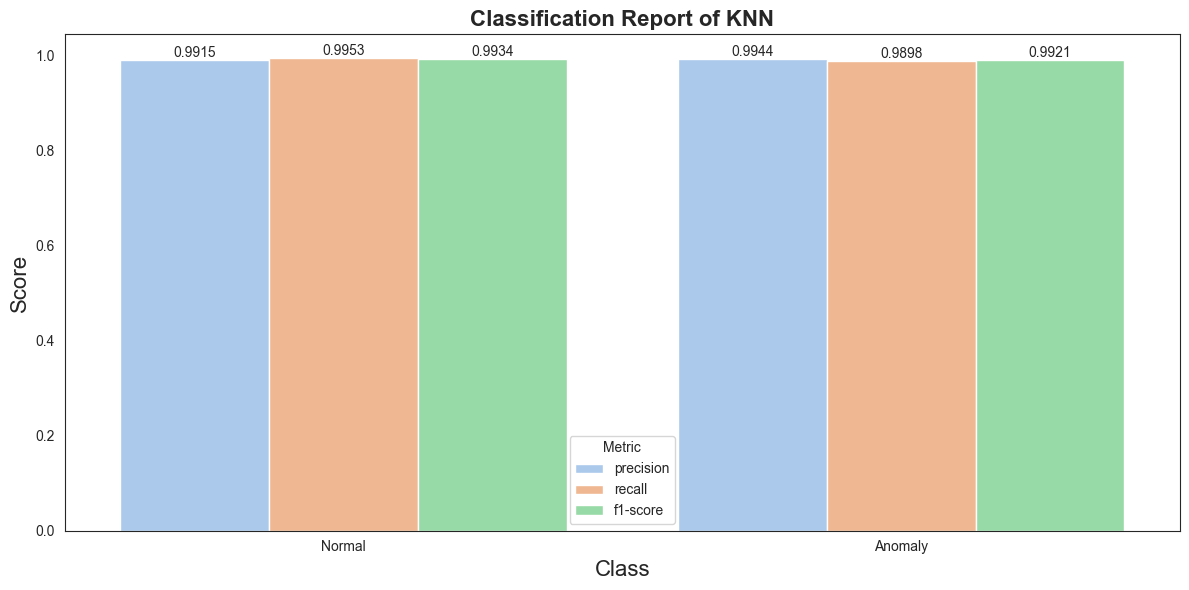

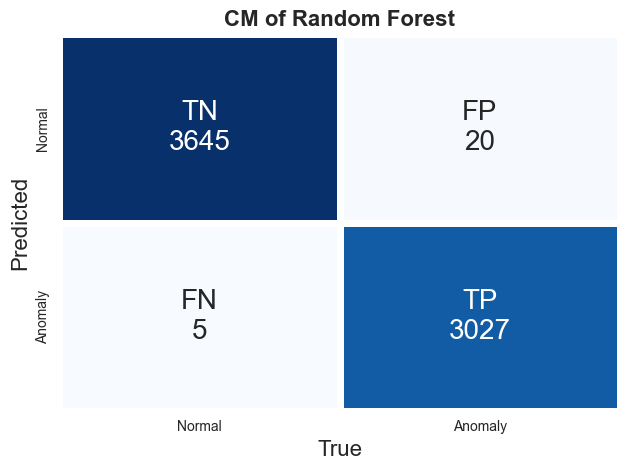

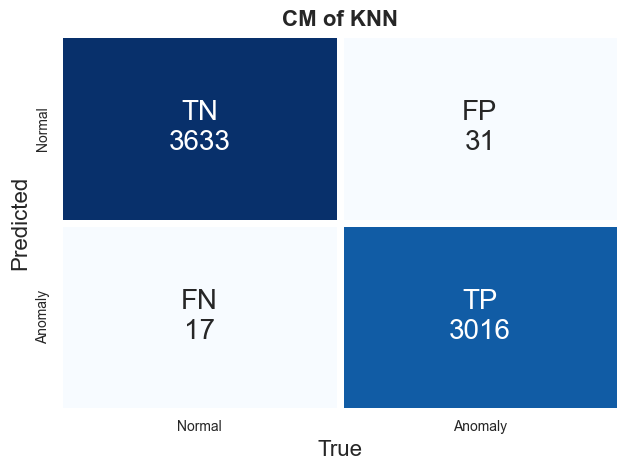

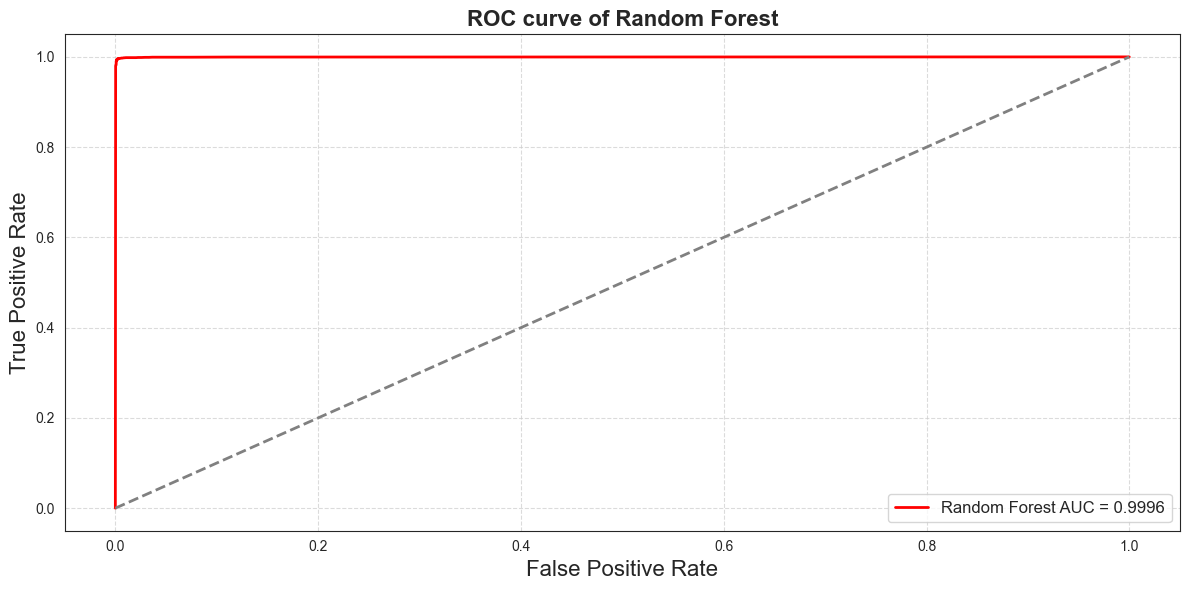

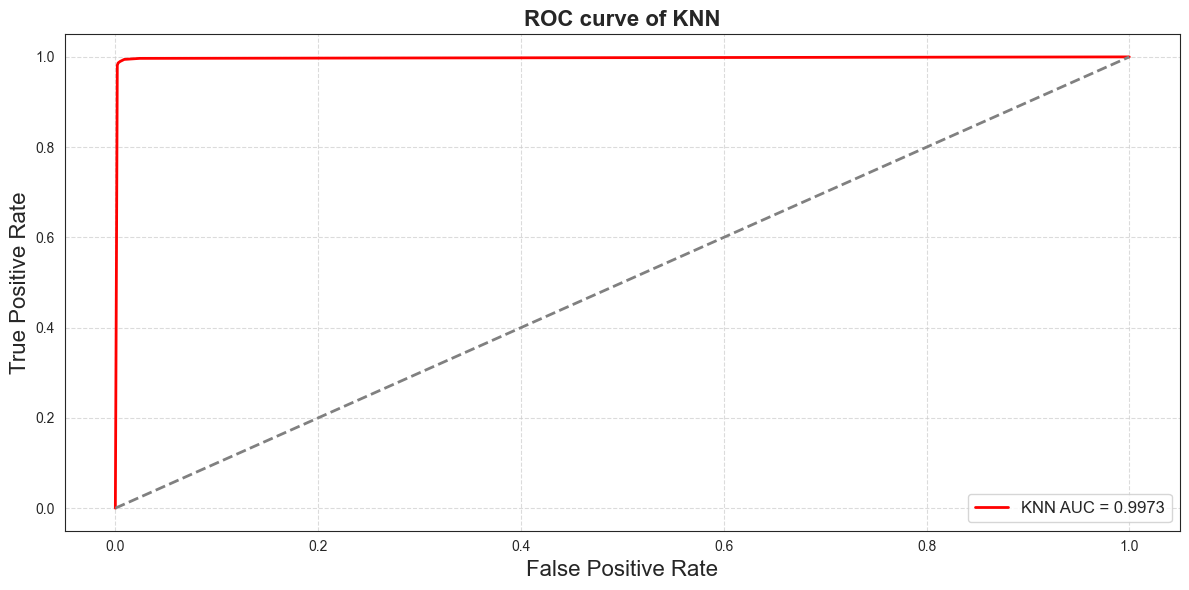

In [41]:
sns.set_style("white")

target_names = ["Normal", "Anomaly"]

for name, model in models:
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred).T 
    tn, fp, fn, tp = cm.ravel()
    specificity = tn / (tn + fp)
    print(f"{name} Specificity: {specificity:.4f}")
    print(f"{name} Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    report = classification_report(y_test, y_pred, target_names=target_names, output_dict=True)
    print(report)
    report_df = pd.DataFrame(report).transpose().reset_index()

    report_melted = report_df.melt(id_vars='index', value_vars=['precision', 'recall', 'f1-score'], var_name='metric', value_name='score')
    report_melted = report_melted[~report_melted['index'].isin(['macro avg', 'weighted avg', 'accuracy'])]

    plt.figure(figsize=(12, 6))
    ax = sns.barplot(x='index', y='score', hue='metric', data=report_melted, palette='pastel')

    for container in ax.containers:
        ax.bar_label(container, fmt='%.4f')

    plt.title(f'Classification Report of {name}', fontsize=16, fontweight='bold')
    plt.xlabel('Class', fontsize=16)
    plt.ylabel('Score', fontsize=16)
    plt.legend(title='Metric')
    plt.tight_layout()
    plt.show()

for name, model in models:
    cm = confusion_matrix(y_test, model.predict(X_test)).T
    tn, fp, fn, tp = cm.ravel()
    annot = [[f'TN\n{tn}', f'FP\n{fp}'], [f'FN\n{fn}', f'TP\n{tp}']]

    sns.heatmap(cm, annot=annot, cmap='Blues', linewidths=5, fmt='', xticklabels=target_names, yticklabels=target_names, cbar=False, annot_kws={'size': 20})
    plt.title(f'CM of {name}', fontsize=16, fontweight='bold')
    plt.xlabel('True', fontsize=16)
    plt.ylabel('Predicted', fontsize=16)
    plt.tight_layout()
    plt.show()

for name, model in models:
    y_pred = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(12, 6))
    plt.plot(fpr, tpr, label=f'{name} AUC = {roc_auc:.4f}', color='red', lw=2)
    plt.plot([0, 1], [0, 1], linestyle='--', color='grey', lw=2)
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.title(f'ROC curve of {name}', fontsize=16, fontweight='bold')
    plt.legend(loc='lower right', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

In [42]:
X_train = data.drop(columns=['class'])
y_train = data['class']

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train[quantitative])

for name, model in models:
    scores = cross_val_score(model, X_train, y_train, cv=10, scoring='accuracy')
    print(f"{name} Cross Validation Accuracy: {scores.mean():.4f} (+/- {scores.std() * 2:.4f})")

Random Forest Cross Validation Accuracy: 0.9967 (+/- 0.0019)
KNN Cross Validation Accuracy: 0.9932 (+/- 0.0036)


In [44]:
param_grids = {
    'Random Forest': {
        'n_estimators': list(range(100, 500, 50)),
        'max_features': ['sqrt', 'log2'],
        'max_depth': [None, 10, 20, 30],
        'criterion': ['gini', 'entropy']
    },
    'KNN': {
        'n_neighbors': [2 ,3, 5, 7, 9, 10],
        'weights': ['uniform', 'distance'],
        'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
        'leaf_size': [10, 20, 30, 40, 50]
    }
}

best_models = {}

for name, model in models:
    grid_search = GridSearchCV(estimator=model, param_grid=param_grids[name], cv=10, scoring='accuracy', verbose=1)
    grid_search.fit(X_train, y_train)
    best_models[name] = grid_search.best_estimator_
    print(f"Best parameters for {name}: {grid_search.best_params_}")
    print(f"Best cross-validation accuracy for {name}: {grid_search.best_score_:.4f}")

for name, model in best_models.items():
    scores = cross_val_score(model, X_train, y_train, cv=10, scoring='accuracy')
    print(f"{name} Cross Validation Accuracy with best parameters: {scores.mean():.4f} (+/- {scores.std() * 2:.4f})")

Fitting 10 folds for each of 128 candidates, totalling 1280 fits


/Users/m4/miniconda3/envs/oz/lib/python3.13/site-packages/numpy/ma/core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best parameters for Random Forest: {'criterion': 'entropy', 'max_depth': None, 'max_features': 'sqrt', 'n_estimators': 400}
Best cross-validation accuracy for Random Forest: 0.9969
Fitting 10 folds for each of 240 candidates, totalling 2400 fits
Best parameters for KNN: {'algorithm': 'auto', 'leaf_size': 10, 'n_neighbors': 2, 'weights': 'distance'}
Best cross-validation accuracy for KNN: 0.9955
Random Forest Cross Validation Accuracy with best parameters: 0.9967 (+/- 0.0018)
KNN Cross Validation Accuracy with best parameters: 0.9955 (+/- 0.0031)


## Holdout validácia po optimalizácii hyperparametrov

Random Forest Specificity: 0.9973
Random Forest Accuracy: 0.9981
{'Normal': {'precision': 0.9972655181843041, 'recall': 0.9991780821917808, 'f1-score': 0.9982208840837553, 'support': 3650.0}, 'Anomaly': {'precision': 0.9990131578947369, 'recall': 0.9967180833606827, 'f1-score': 0.9978643009692788, 'support': 3047.0}, 'accuracy': 0.998058832312976, 'macro avg': {'precision': 0.9981393380395205, 'recall': 0.9979480827762317, 'f1-score': 0.9980425925265171, 'support': 6697.0}, 'weighted avg': {'precision': 0.9980606590231408, 'recall': 0.998058832312976, 'f1-score': 0.9980586459547707, 'support': 6697.0}}


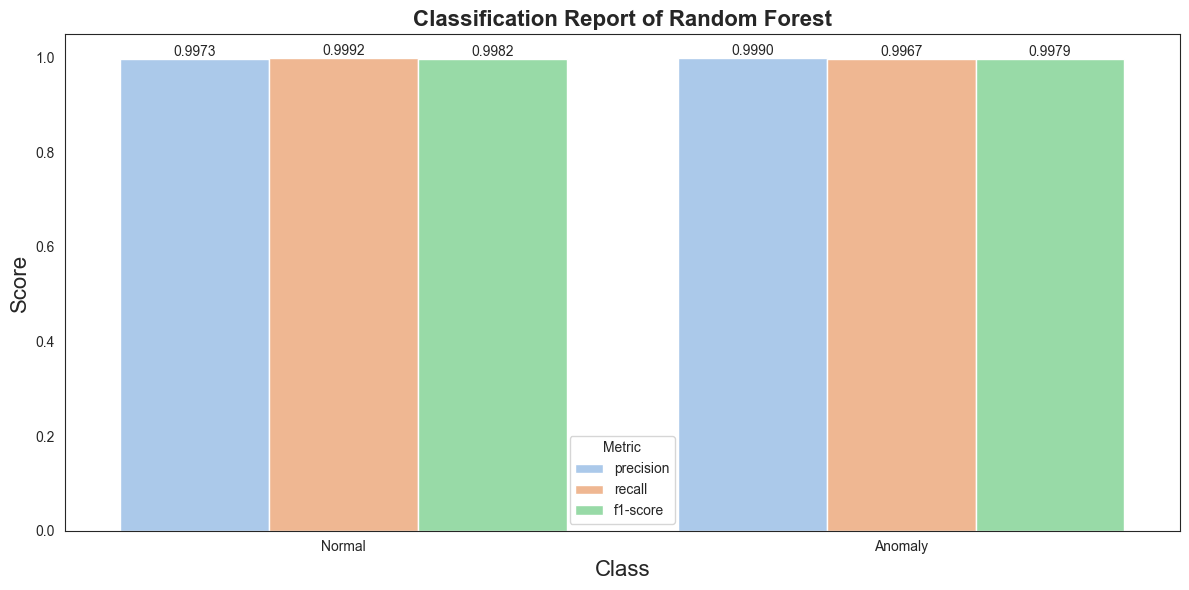

KNN Specificity: 0.9995
KNN Accuracy: 0.9997
{'Normal': {'precision': 0.9994523548740416, 'recall': 1.0, 'f1-score': 0.9997261024376883, 'support': 3650.0}, 'Anomaly': {'precision': 1.0, 'recall': 0.9993436166721366, 'f1-score': 0.9996717005909389, 'support': 3047.0}, 'accuracy': 0.9997013588173809, 'macro avg': {'precision': 0.9997261774370207, 'recall': 0.9996718083360683, 'f1-score': 0.9996989015143136, 'support': 6697.0}, 'weighted avg': {'precision': 0.999701522366769, 'recall': 0.9997013588173809, 'f1-score': 0.9997013506940648, 'support': 6697.0}}


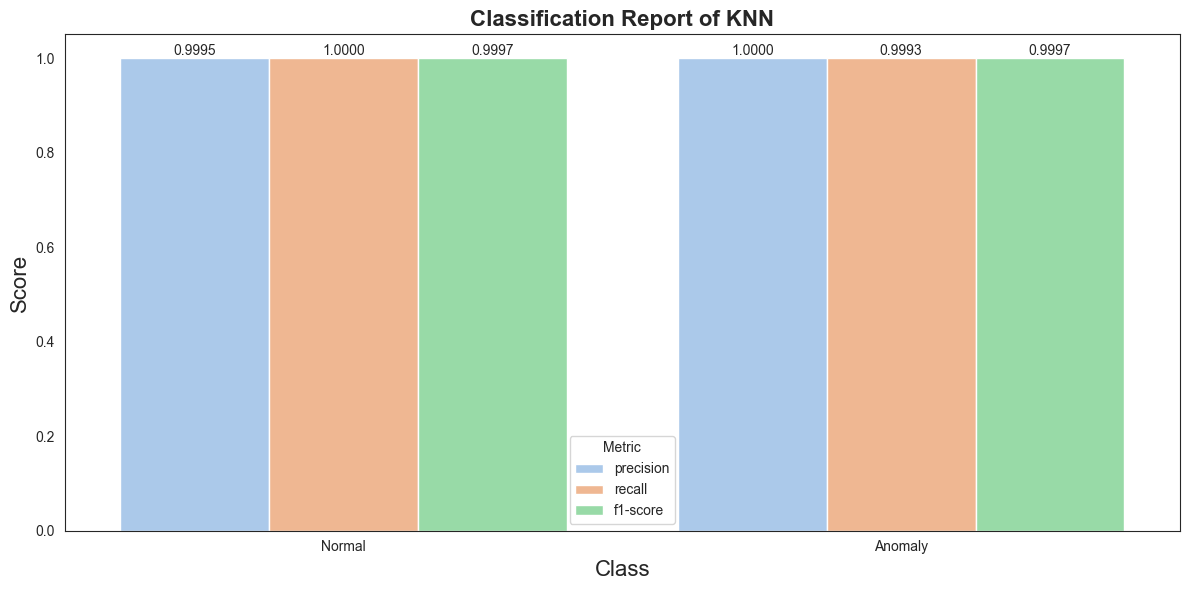

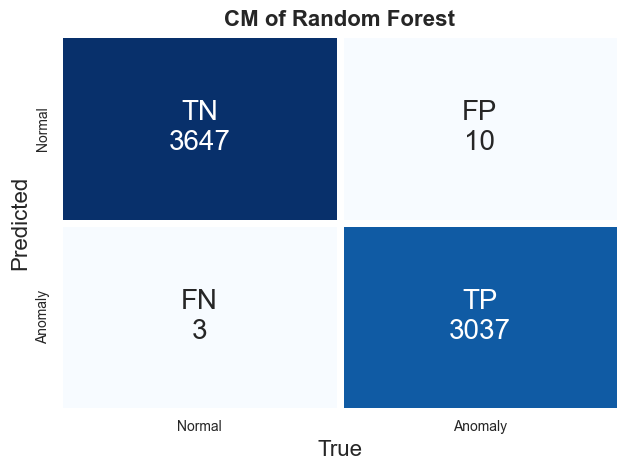

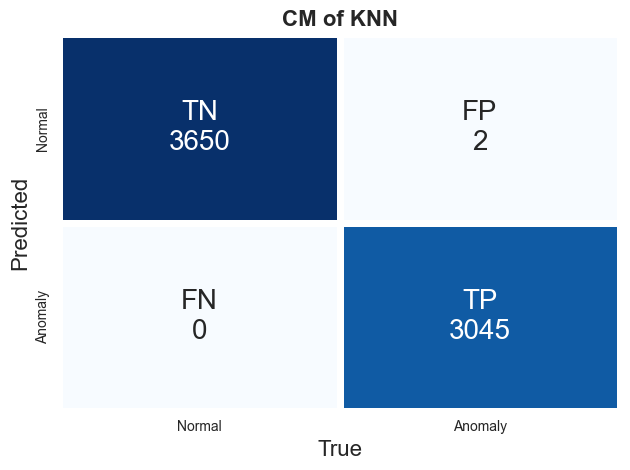

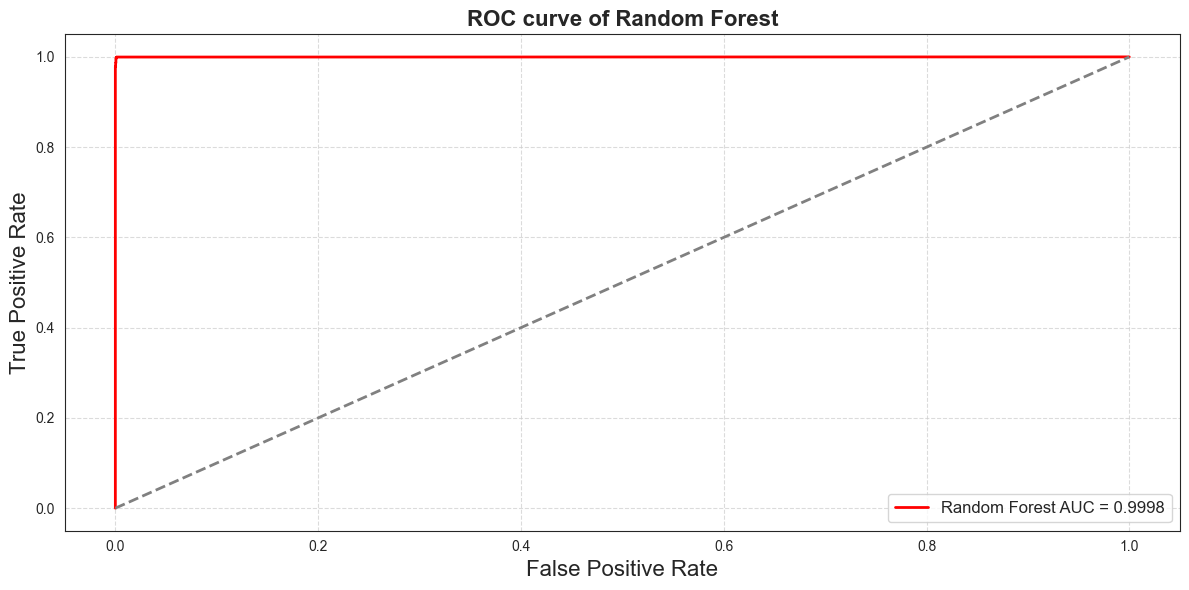

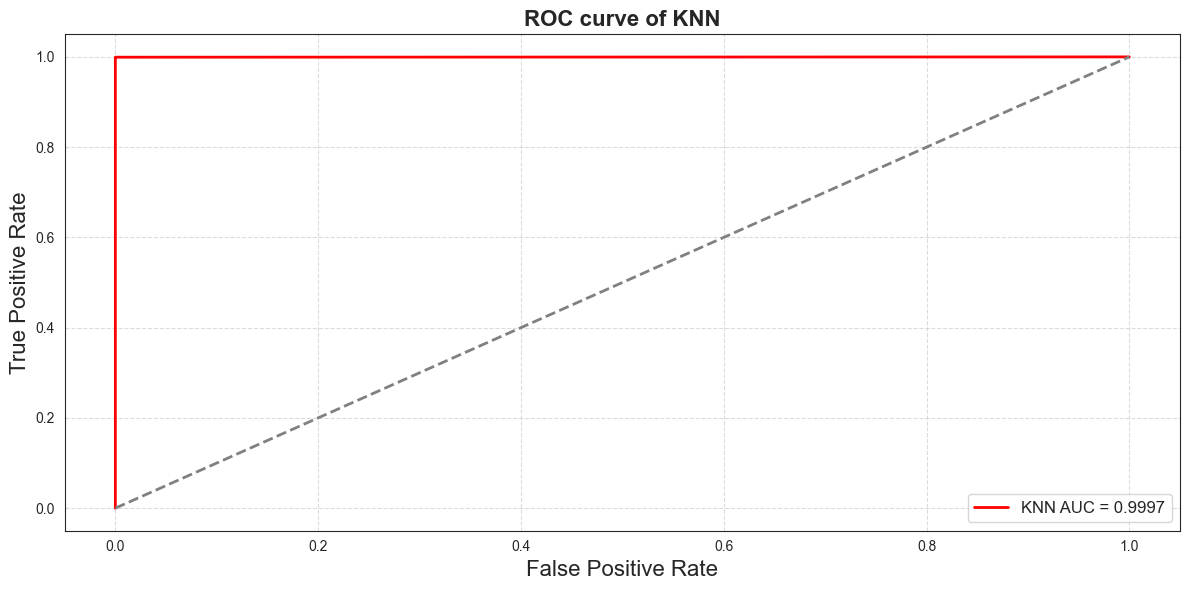

In [49]:
for name, model in best_models.items():
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred).T
    tn, fp, fn, tp = cm.ravel()
    specificity = tn / (tn + fp)
    print(f"{name} Specificity: {specificity:.4f}")
    print(f"{name} Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    report = classification_report(y_test, y_pred, target_names=target_names, output_dict=True)
    print(report)
    report_df = pd.DataFrame(report).transpose().reset_index()

    report_melted = report_df.melt(id_vars='index', value_vars=['precision', 'recall', 'f1-score'], var_name='metric',
                                   value_name='score')
    report_melted = report_melted[~report_melted['index'].isin(['macro avg', 'weighted avg', 'accuracy'])]

    plt.figure(figsize=(12, 6))
    ax = sns.barplot(x='index', y='score', hue='metric', data=report_melted, palette='pastel')

    for container in ax.containers:
        ax.bar_label(container, fmt='%.4f')

    plt.title(f'Classification Report of {name}', fontsize=16, fontweight='bold')
    plt.xlabel('Class', fontsize=16)
    plt.ylabel('Score', fontsize=16)
    plt.legend(title='Metric')
    plt.tight_layout()
    plt.show()

for name, model in best_models.items():
    cm = confusion_matrix(y_test, model.predict(X_test)).T
    tn, fp, fn, tp = cm.ravel()
    annot = [[f'TN\n{tn}', f'FP\n{fp}'], [f'FN\n{fn}', f'TP\n{tp}']]

    sns.heatmap(cm, annot=annot, cmap='Blues', linewidths=5, fmt='', xticklabels=target_names, yticklabels=target_names,
                cbar=False, annot_kws={'size': 20})
    plt.title(f'CM of {name}', fontsize=16, fontweight='bold')
    plt.xlabel('True', fontsize=16)
    plt.ylabel('Predicted', fontsize=16)
    plt.tight_layout()
    plt.show()

for name, model in best_models.items():
    y_pred = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(12, 6))
    plt.plot(fpr, tpr, label=f'{name} AUC = {roc_auc:.4f}', color='red', lw=2)
    plt.plot([0, 1], [0, 1], linestyle='--', color='grey', lw=2)
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.title(f'ROC curve of {name}', fontsize=16, fontweight='bold')
    plt.legend(loc='lower right', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
